### Example benchmarking comparison between 2 Qiskit transpilers


In [1]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

In [2]:
from transpile_benchy.interfaces.qasm_interface import QASMBench

qasm_bench = QASMBench(size="medium")
# print(qasm_bench)  # list of names of all possible circuits for qasm

In [3]:
from transpile_benchy.metrics.gate_counts import DepthMetric, TotalMetric

depth_metric = DepthMetric()
total_metric = TotalMetric()

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_heavy_hex(5)

In [4]:
from transpile_benchy.passmanagers.qiskit_baseline import QiskitBaseline

baseline1 = QiskitBaseline(optimization_level=1, coupling_map=coupling_map)
baseline2 = QiskitBaseline(optimization_level=2, coupling_map=coupling_map)
baseline3 = QiskitBaseline(optimization_level=3, coupling_map=coupling_map)

In [5]:
benchmark = Benchmark(
    transpilers=[baseline1, baseline2, baseline3],
    metrics=[depth_metric, total_metric],
    submodules=[qasm_bench],  # FIXME, use Library
    logger=transpile_benchy_logger,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...


Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | cx
  0.00% =    0/1    	 | 2.00	 | cx.cx
100.00% =    1/1    	 | 3.00	 | cx.cx.cx


Running circuits for QASMBench: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]


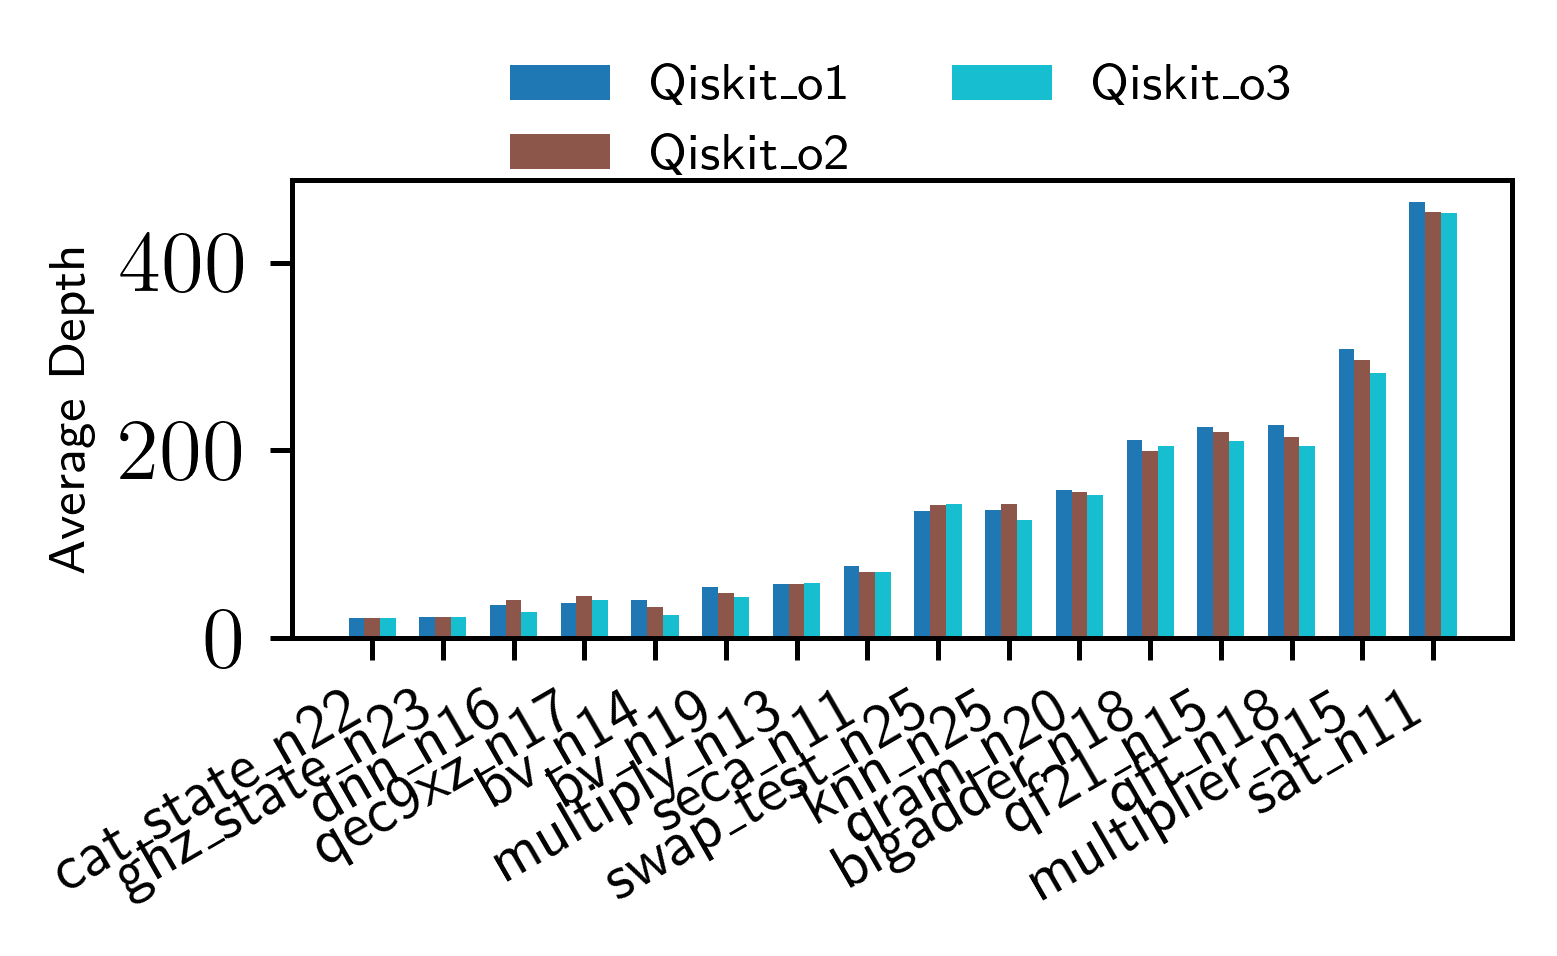

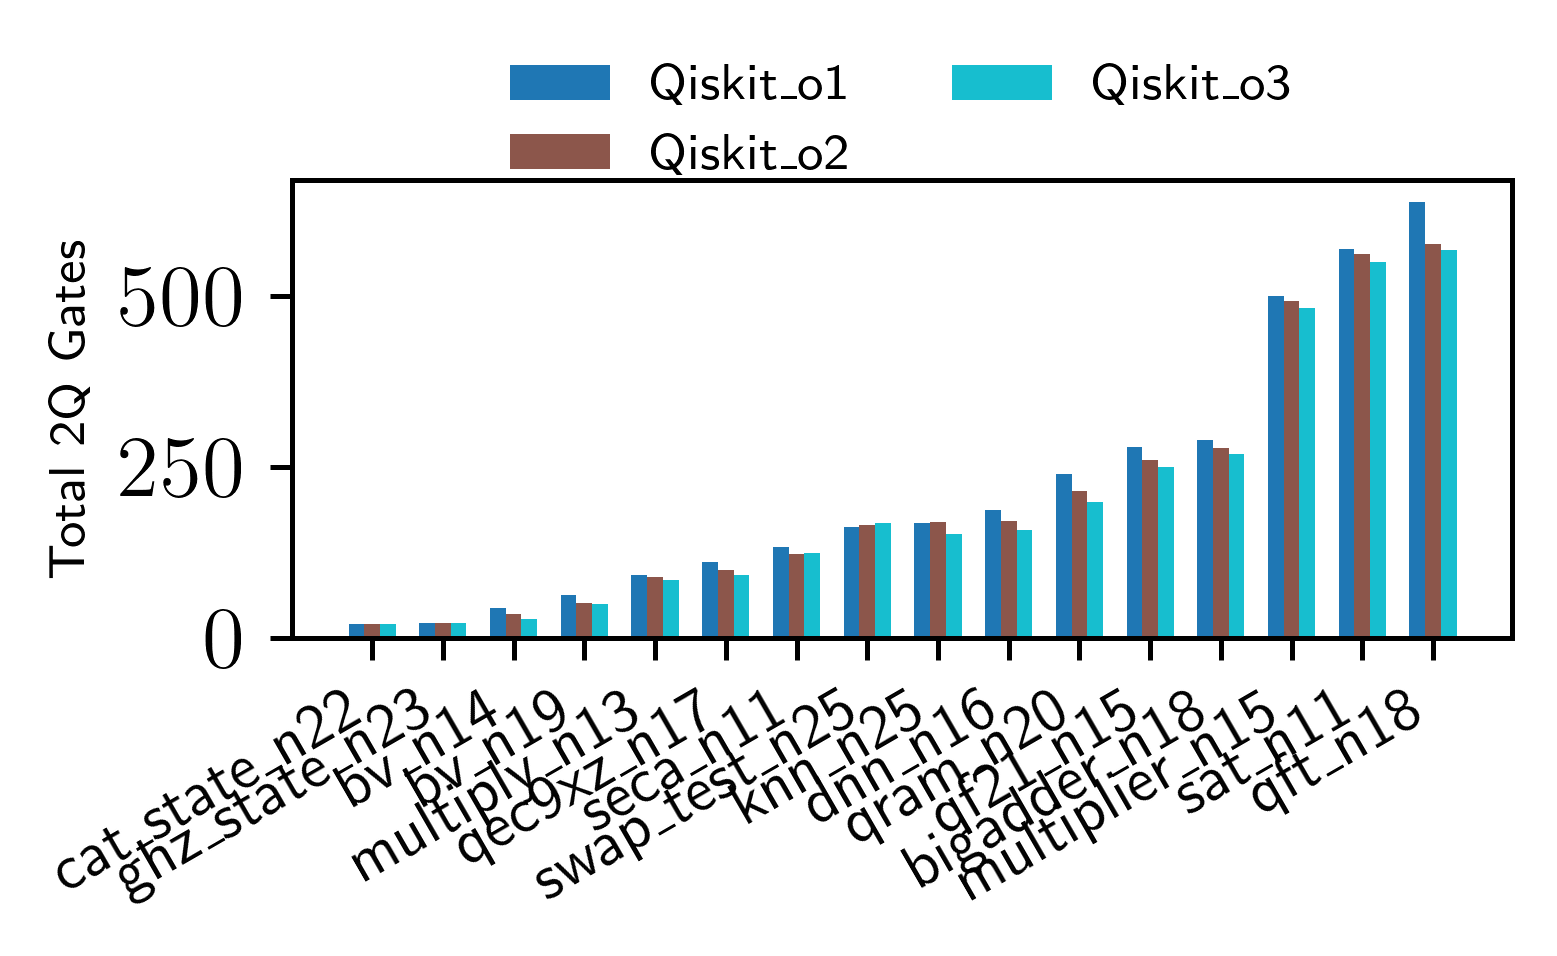

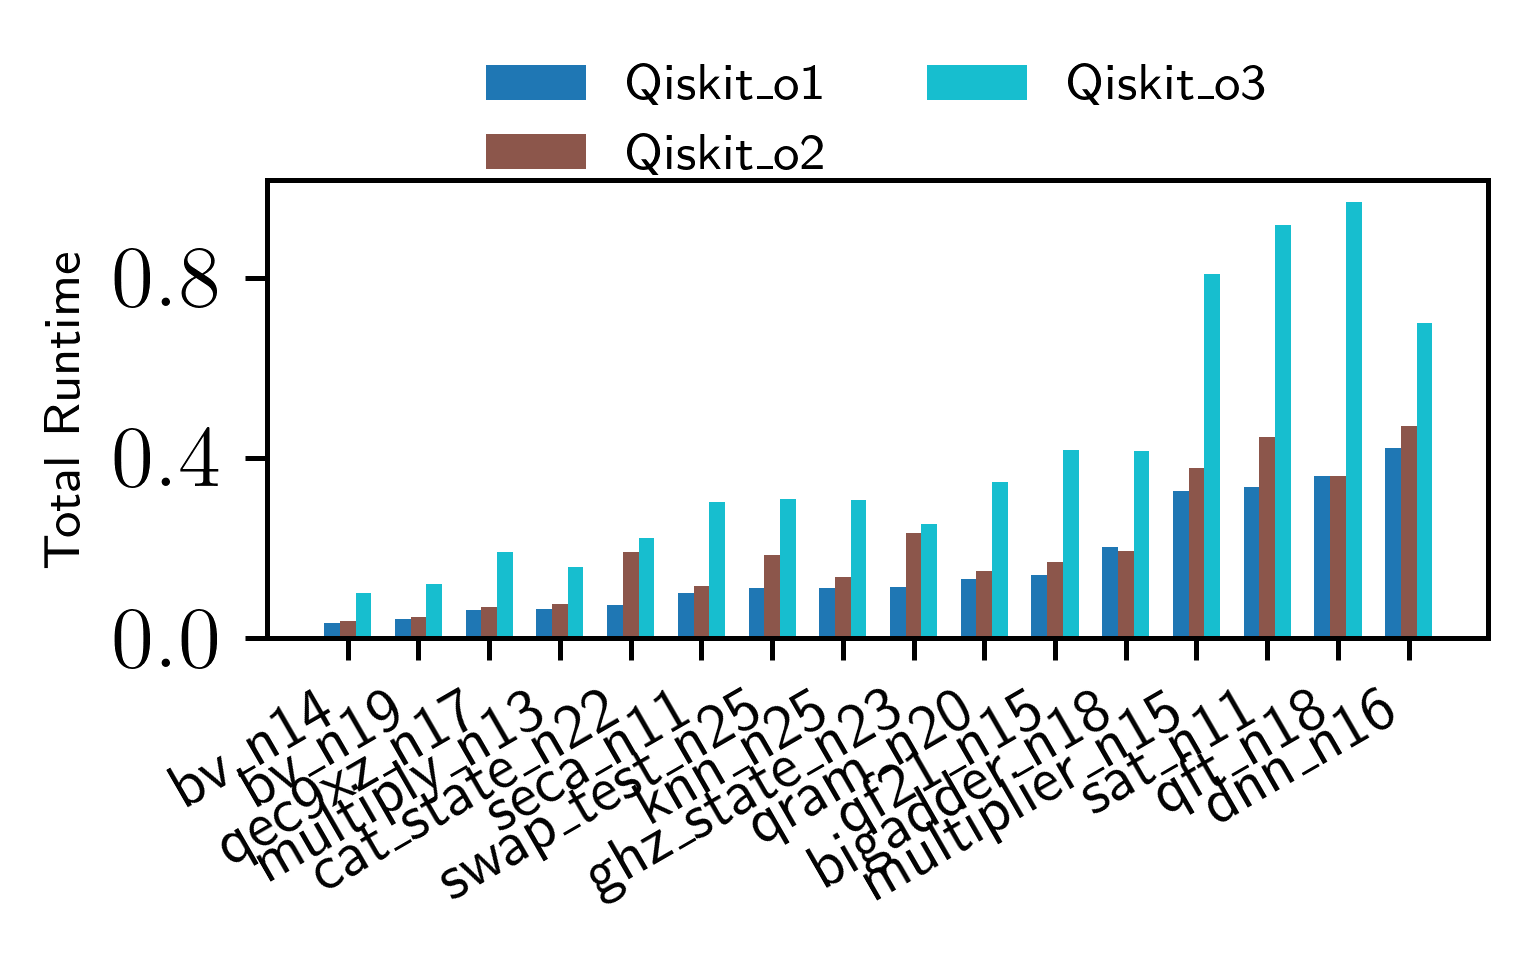

In [6]:
from transpile_benchy.render import plot_benchmark

plot_benchmark(benchmark)